IndoBert Model

In [1]:
import torch
print(f"Is GPU available? {torch.cuda.is_available()}")
print(f"Device Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

Is GPU available? True
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


Kolom Data Latih: ['ID', 'label', 'tanggal', 'judul', 'narasi', 'nama file gambar']
label
1    3465
0     766
Name: count, dtype: int64
✅ USING FULL DATASET (GPU POWERED):
label
1    3465
0    3465
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\natha\AppData\Local\Temp\ipykernel_26916\2282939590.py:114: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/2:   0%|          | 0/434 [00:00<?, ?it/s]

C:\Users\natha\AppData\Local\Temp\ipykernel_26916\2282939590.py:128: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Avg Loss: 0.4289


Epoch 2/2:   0%|          | 0/434 [00:00<?, ?it/s]


Avg Loss: 0.0919


Evaluating:   0%|          | 0/434 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

    Non-Hoax       0.98      1.00      0.99      3465
        Hoax       1.00      0.98      0.99      3465

    accuracy                           0.99      6930
   macro avg       0.99      0.99      0.99      6930
weighted avg       0.99      0.99      0.99      6930



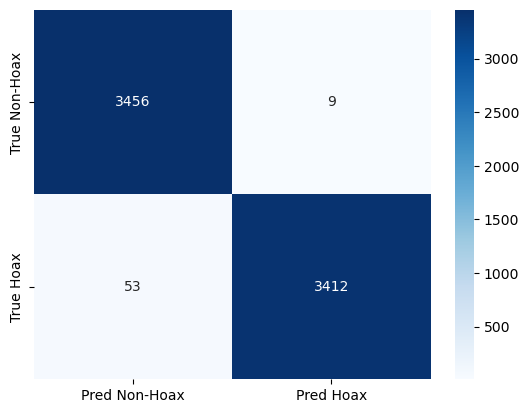


✅ Model saved to 'balanced_hoax_detector/'


In [2]:
import pandas as pd
import numpy as np
import re, string, torch, time
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================
# 1. LOAD DATA
# ==========================================================
train_df = pd.read_csv("Data_latih.csv")
test_df = pd.read_csv("Data_uji.csv")

print("Kolom Data Latih:", list(train_df.columns))

# Use narasi + label
train_df = train_df[['narasi', 'label']].rename(columns={'narasi': 'text'})
test_df = test_df[['narasi']].rename(columns={'narasi': 'text'})

# ==========================================================
# 2. FIX LABEL (0 = Non-Hoax, 1 = Hoax)
# ==========================================================
def fix_label(x):
    x = str(x).lower().strip()
    if x in ["1", "hoax"]:
        return 1
    return 0

train_df["label"] = train_df["label"].apply(fix_label)

print(train_df["label"].value_counts())

# ==========================================================
# 3. BALANCE DATA (GPU MODE - FULL DATA)
# ==========================================================
hoax = train_df[train_df["label"] == 1]
nonhoax = train_df[train_df["label"] == 0]

# Balance the data so both have the same amount (Upsampling)
if len(hoax) > len(nonhoax):
    nonhoax = nonhoax.sample(len(hoax), replace=True, random_state=42)
else:
    hoax = hoax.sample(len(nonhoax), replace=True, random_state=42)

train_df = pd.concat([hoax, nonhoax]).sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ USING FULL DATASET (GPU POWERED):")
print(train_df['label'].value_counts())

# ==========================================================
# 4. CLEAN TEXT
# ==========================================================
factory = StopWordRemoverFactory()
stopwords = factory.create_stop_word_remover()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = stopwords.remove(text)
    return text.strip()

train_df["clean_text"] = train_df["text"].apply(clean_text)

# ==========================================================
# 5. TOKENIZER + DATASET
# ==========================================================
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = NewsDataset(train_df['clean_text'].tolist(), train_df['label'].tolist(), tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# ==========================================================
# 6. MODEL SETUP
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 2
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

scaler = torch.cuda.amp.GradScaler()

# ==========================================================
# 7. TRAINING
# ==========================================================
model.train()
for epoch in range(epochs):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items()}

        with torch.cuda.amp.autocast():
            outputs = model(**inputs)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    print(f"\nAvg Loss: {total_loss/len(train_loader):.4f}")

# ==========================================================
# 8. EVALUATION
# ==========================================================
model.eval()
preds, labels = [], []

for batch in tqdm(train_loader, desc="Evaluating"):
    inputs = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    labels.extend(inputs["labels"].cpu().numpy())

print("\nClassification Report:")
print(classification_report(labels, preds, target_names=["Non-Hoax", "Hoax"]))

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred Non-Hoax","Pred Hoax"], yticklabels=["True Non-Hoax","True Hoax"])
plt.show()

# ==========================================================
# 9. SAVE MODEL
# ==========================================================
model.save_pretrained("balanced_hoax_detector")
tokenizer.save_pretrained("balanced_hoax_detector")

print("\n✅ Model saved to 'balanced_hoax_detector/'")


Bert Model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\natha\AppData\Local\Temp\ipykernel_26916\2037039458.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


mBERT Epoch 1/2:   0%|          | 0/434 [00:00<?, ?it/s]

C:\Users\natha\AppData\Local\Temp\ipykernel_26916\2037039458.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\natha\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Avg Loss mBERT: 0.6292


mBERT Epoch 2/2:   0%|          | 0/434 [00:00<?, ?it/s]

Avg Loss mBERT: 0.3569


Evaluasi mBERT:   0%|          | 0/434 [00:00<?, ?it/s]


=== Classification Report mBERT ===
              precision    recall  f1-score   support

    Non-Hoax       0.88      0.96      0.92      3465
        Hoax       0.95      0.87      0.91      3465

    accuracy                           0.92      6930
   macro avg       0.92      0.92      0.92      6930
weighted avg       0.92      0.92      0.92      6930



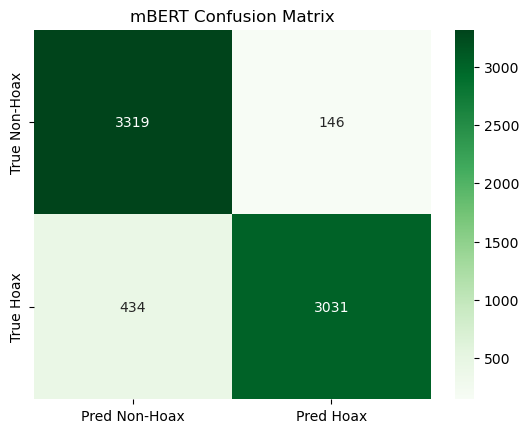


✅ mBERT model saved to 'mbert_hoax_detector/'


In [3]:
# ==========================================================
# TRAINING MODEL BERT-base-multilingual-cased (mBERT)
# ==========================================================
from transformers import BertTokenizer, BertForSequenceClassification

MBERT_NAME = "bert-base-multilingual-cased"

tokenizer_mbert = BertTokenizer.from_pretrained(MBERT_NAME)

mbert_dataset = NewsDataset(
    train_df['clean_text'].tolist(),
    train_df['label'].tolist(),
    tokenizer_mbert
)

mbert_loader = DataLoader(mbert_dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mbert_model = BertForSequenceClassification.from_pretrained(MBERT_NAME, num_labels=2)
mbert_model.to(device)

optimizer = AdamW(mbert_model.parameters(), lr=2e-5)
epochs = 2
total_steps = len(mbert_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)
scaler = torch.cuda.amp.GradScaler()

# ================= TRAIN =================
mbert_model.train()
for epoch in range(epochs):
    total_loss = 0
    progress_bar = tqdm(mbert_loader, desc=f"mBERT Epoch {epoch+1}/{epochs}")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items()}
        
        with torch.cuda.amp.autocast():
            outputs = mbert_model(**inputs)
            loss = outputs.loss
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    print(f"Avg Loss mBERT: {total_loss/len(mbert_loader):.4f}")

# ================= EVALUATION =================
mbert_model.eval()
preds, labels_true = [], []

for batch in tqdm(mbert_loader, desc="Evaluasi mBERT"):
    inputs = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = mbert_model(**inputs)

    preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    labels_true.extend(inputs["labels"].cpu().numpy())

print("\n=== Classification Report mBERT ===")
print(classification_report(labels_true, preds, target_names=["Non-Hoax", "Hoax"]))

# Confusion matrix
cm = confusion_matrix(labels_true, preds)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Greens',
    xticklabels=["Pred Non-Hoax","Pred Hoax"],
    yticklabels=["True Non-Hoax","True Hoax"]
)
plt.title("mBERT Confusion Matrix")
plt.show()

# ================= SAVE =================
mbert_model.save_pretrained("mbert_hoax_detector")
tokenizer_mbert.save_pretrained("mbert_hoax_detector")

print("\n✅ mBERT model saved to 'mbert_hoax_detector/'")
